### Machine Learning project: build a lending model 
The task is to build a machine learning model to predict wether borrowers are likely to pay or default on their loan. Two main questions to address in the lending industy:

1) How risky is the borrowe?

2) Given the borrower's risk, should we lend him/her?

I will refer on https://www.dataquest.io/blog/machine-learning-preparing-data/ example and expand it with my own knowledge. In this notebook, i will focus on cleaning the data.

#### Step 1: data pre-processing
In this part, I show how to clean and remove unnecessary features. I will show how to identify *constant features*, *duplicate feature*, *duplicate rows*, and *features with a high number of missing values*

In [4]:
import pandas as pd
import missingno as msno 
import numpy as np
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

###### Load the data
skip unnecessary columns: *desc*, *url*.
Skip the first row

In [5]:
loans_2007 = pd.read_csv('data/lending_club_loans.csv', skiprows=1, low_memory=False)
loans_2007
shape1 = loans_2007.shape
half_count = len(loans_2007)/2

# Drop any columns with 50% of missing values
loans_2007 = loans_2007.dropna(thresh = half_count, axis=1)
shape2 = loans_2007.shape

# Drop columns containing both url and desc == not useful information for our model
loans_2007 = loans_2007.drop(['url', 'desc'], axis=1)
shape3 = loans_2007.shape

# Write columns list in a variable and check if the columns have been deleted
col_list = list(loans_2007.columns)

# def check_col(cols_2_check, df):
#     ''' Check if given elements exists in columns list of dataframe (df) or not.
#         It returns the result as bool'''
#     resultList = [];
#     for col in cols_2_check:
#         if col in df.columns:
#             resultList[col] = True
#         else:
#             resultList[col] = False
            
#     return resultList

print("shape 1", shape1, "shape 2", shape2, "shape 3", shape3)

col_list
elem = ['index']
elem in col_list
loans_2007.head(2)

shape 1 (42538, 115) shape 2 (42538, 58) shape 3 (42538, 56)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,Jan-2015,171.62,Sep-2016,744.0,740.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,Sep-2016,499.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


We see that there are approximately 43000 rows and each has 56 features including the target variable

#### Extracting the target variable

In [6]:
# The LCDDataDictionary provides us with an explanation of each row
data_dictionary = pd.read_csv('data/LCDataDictionary.csv')
print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())
data_dictionary.head()

117
['LoanStatNew', 'Description']


,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


In [7]:
# Rename the columns 
data_dictionary = data_dictionary.rename(columns={"LoanStatNew" : "name", "Description" : "description"})

###### Join the first row of loans 2007 to data dictionary
1. name — contains the column names of loans_2007
2. dtypes — contains the data types of the loans_2007 columns
3. first value — contains the values of loans_2007 first row
4. description — explains what each column in loans_2007 represents

In [8]:
loans_2007_dtypes = pd.DataFrame(loans_2007.dtypes, columns=['dtypes'])
ch1= loans_2007_dtypes.head(2)

loans_2007_dtypes = loans_2007_dtypes.reset_index()
ch2 = loans_2007_dtypes.head(2)

loans_2007_dtypes['name'] = loans_2007_dtypes['index']
ch3 = loans_2007_dtypes.head(2)

loans_2007_dtypes = loans_2007_dtypes[['name','dtypes']]
ch4 = loans_2007_dtypes.head(2)

loans_2007_dtypes['first value'] = loans_2007.loc[0].values

#print(ch1, ch2, ch3, ch4, ch5)
#print(loans_2007_dtypes.head(3)) 
print(loans_2007_dtypes.head(3)) 
data_dictionary.head(3)


preview = loans_2007_dtypes.merge(data_dictionary, on='name', how= 'left')
print(list(preview.columns))
preview.head()

        name   dtypes first value
0         id   object     1077501
1  member_id  float64  1.2966e+06
2  loan_amnt  float64        5000
['name', 'dtypes', 'first value', 'description']


,name,dtypes,first value,description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,5000,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,4975,The total amount committed by investors for that loan at that point in time.


##### remove unnecessary rows
Let's focus on clusters of borrowers instead of individuals and analyse the features by block of 19 features.

In [9]:
preview[0:18]

,name,dtypes,first value,description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,5000,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,4975,The total amount committed by investors for that loan at that point in time.
5,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,int_rate,object,10.65%,Interest Rate on the loan
7,installment,float64,162.87,The monthly payment owed by the borrower if the loan originates.
8,grade,object,B,LC assigned loan grade
9,sub_grade,object,B2,LC assigned loan subgrade


In [10]:
# What may be useful for our model, is to focus on clusters of borrowers instead of individuals. So we will drop these features:
drop_list = ['id', 'member_id',  'funded_amnt', 'funded_amnt_inv', 'int_rate', 'sub_grade', 'emp_title', 'issue_d']
loans_2007 = loans_2007.drop(drop_list, axis=1)
list(loans_2007.columns)

['loan_amnt',
 'term',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

In [11]:
# Second group columns
preview[19:38]

,name,dtypes,first value,description
19,title,object,Computer,The loan title provided by the borrower
20,zip_code,object,860xx,The first 3 numbers of the zip code provided by the borrower in the loan application.
21,addr_state,object,AZ,The state provided by the borrower in the loan application
22,dti,float64,27.65,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
23,delinq_2yrs,float64,0,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
24,earliest_cr_line,object,Jan-1985,The month the borrower's earliest reported credit line was opened
25,fico_range_low,float64,735,The lower boundary range the borrower’s FICO at loan origination belongs to.
26,fico_range_high,float64,739,The upper boundary range the borrower’s FICO at loan origination belongs to.
27,inq_last_6mths,float64,1,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
28,open_acc,float64,3,The number of open credit lines in the borrower's credit file.


After analysing carefully this range, we understand that the features we need for our model are *fico_range_low*, *fico_range_high*
, *last_fico_range_low*, and *last_fico_range_high* columns. 

According to wikipedia, The FICO model is used by the vast majority of banks and credit grantors, and is based on consumer credit files of the three national credit bureaus: Experian, Equifax, and TransUnion. Because a consumer's credit file may contain different information at each of the bureaus, FICO scores can vary depending on which bureau provides the information to FICO to generate the score. 

The question is: which one the FICO score can help to predict accurate information about the borrower?
The *last_fico_range_low* and *last_fico_range_high* represent the update to the borrowers score. So we will use *fico_range_low*, *fico_range_high* to help to build  the model.


In [12]:
# We will drop all the other features
drop_cols = ['zip_code','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv']
loans_2007 = loans_2007.drop(drop_cols, axis=1)
print(list(loans_2007.columns))

['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens']


In [13]:
# Let us look at the last block
preview[38:]

,name,dtypes,first value,description
38,total_rec_prncp,float64,5000,Principal received to date
39,total_rec_int,float64,863.16,Interest received to date
40,total_rec_late_fee,float64,0,Late fees received to date
41,recoveries,float64,0,post charge off gross recovery
42,collection_recovery_fee,float64,0,post charge off collection fee
43,last_pymnt_d,object,Jan-2015,Last month payment was received
44,last_pymnt_amnt,float64,171.62,Last total payment amount received
45,last_credit_pull_d,object,Sep-2016,The most recent month LC pulled credit for this loan
46,last_fico_range_high,float64,744,The upper boundary range the borrower’s last FICO pulled belongs to.
47,last_fico_range_low,float64,740,The lower boundary range the borrower’s last FICO pulled belongs to.


In [14]:
# Let us drop non relevant features
drop_cols = ['total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee', 'last_pymnt_d','last_pymnt_amnt']
loans_2007 = loans_2007.drop(drop_cols, axis=1)
list(loans_2007.columns)

['loan_amnt',
 'term',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

#### Investigating FICO Score Columns

In [15]:
# Let s print the short summary of the New data frame including the null_counts:
#loans_2007.info(verbose = True, null_counts = True, memory_usage = 'deep')

# From this we all have the information about all the columns and the type of data each column contains.
# . dtypes: float64(21), object(15)...means that our dataset has 21 float64 types and 15 columns contain "string"
# Print this summary of columns count and its dtypes but not per column information:
# by default, the output is printed to sys.stdout: I will pass a writable buffer so i can further process the output
import io
buffer = io.StringIO()
loans_2007.info(verbose = True, null_counts = True, buf = buffer, memory_usage = 'deep')
s = buffer.getvalue()
with open("loans2007_info.txt", "w", encoding = "utf-8") as f:
    f.write(s)

# Let us some quick statistic. We can find ut parameters like count, mean, std, and max
loans_2007.describe()

# Let s include the columns that include objects datatypes since they mostly include text strings.
loans_2007.describe(include=np.object)


,term,grade,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,earliest_cr_line,revol_util,initial_list_status,last_credit_pull_d,application_type
count,42535,42535,41423,42535,42535,42535,42535,42535,42522,42535,42506,42445,42535,42531,42535
unique,2,7,11,5,3,9,2,14,21264,50,530,1119,1,111,1
top,36 months,B,10+ years,RENT,Not Verified,Fully Paid,n,debt_consolidation,Debt Consolidation,CA,Oct-1999,0%,f,Sep-2016,INDIVIDUAL
freq,31534,12389,9369,20181,18758,33586,42534,19776,2259,7429,393,1070,42535,16232,42535


Take a look at *term*, *emp_length*, and *loan_status*. The dataset contains 2 different of payment plan and 9 different of loan status.
Morever, most of the loan are fully paid over a period of 36 months.

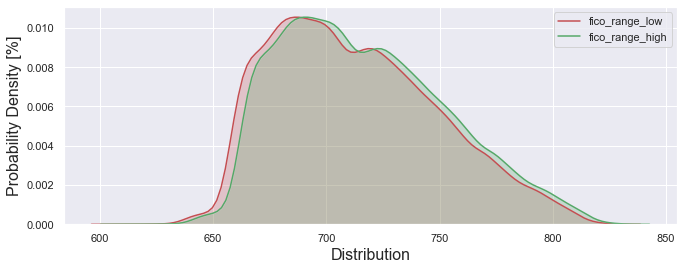

In [16]:
# Let us investigate the 02 columns
Y = loans_2007[['fico_range_low', 'fico_range_high']]

# Plot missing value map
# Y.plot(kind='kde')
# plt.show()

sns.set(rc={'figure.figsize':(11, 4)})

# #Y.plot(linewidth=0.5);
cols_plot = ['fico_range_low', 'fico_range_high']

# axes = Y[cols_plot].plot(kind='kde',marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

# for ax in axes:
#     ax.set_ylabel('Probability Density in %')

#I could not plo the histogram on top because of missing values

p1=sns.kdeplot(Y['fico_range_low'], shade=True, color="r")
p2=sns.kdeplot(Y['fico_range_high'],shade=True, color="g")
plt.ylabel('Probability Density [%]', fontsize=16)
plt.xlabel('Distribution', fontsize=16)

plt.show()

Looking at these shapes, we see that the distribution is not symetric. I may need to apply a Box Cox transformation to transform this
non dependent variables into a normal shape. Before we continue, let s check if the data has NAN values.

In [17]:
# Creating bool series True for non NAN values and False for a null value
bool_series = pd.notnull(loans_2007)
bool_series

# Display the data with NAN
loans_2007[bool_series]

# Let us print the number of missing value in two features for example
n_missing_values = Y.isnull().sum()
print(n_missing_values )

# We do have only 03 NAN data. Let s remove them
loans_2007.dropna(subset = cols_plot, inplace = True)

fico_range_low     3
fico_range_high    3
dtype: int64


42535


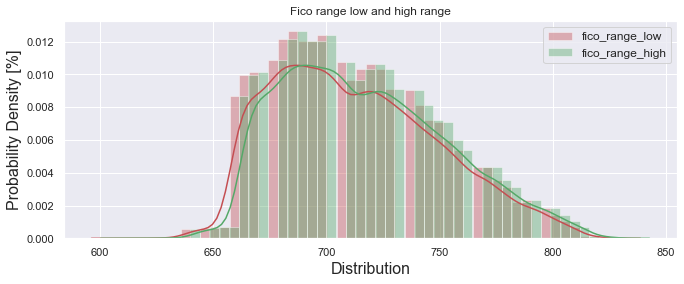

,fico_range_low,fico_range_high
count,42535.000000,42535.000000
mean,713.052545,717.052545
std,36.188439,36.188439
min,610.000000,614.000000
25%,685.000000,689.000000
50%,710.000000,714.000000
75%,740.000000,744.000000
max,825.000000,829.000000


In [19]:
# Check if the NAN were removed
print(loans_2007.shape[0]) # 03 points have been effectively removed

# Now we can plot the histogram and the KDE alltogether
Y = loans_2007[['fico_range_low', 'fico_range_high']]
p1=sns.distplot(Y['fico_range_low'], hist = True, kde = True, color = 'r', label = 'fico_range_low', bins = 50)
p1=sns.distplot(Y['fico_range_high'], hist = True, kde = True, color = 'g', label = 'fico_range_high', bins = 50)

plt.ylabel('Probability Density [%]', fontsize=16)
plt.xlabel('Distribution', fontsize=16)
plt.legend(prop={'size': 12})
plt.title('Fico range low and high range')
plt.show()

Y.describe()

In [59]:
# Create a cell "fico_average" == containing the average of fico_ran ge_low and fico_range_high

loans_2007['fico_average'] = (loans_2007['fico_range_high'] + loans_2007['fico_range_low']) / 2
cols = ['fico_range_low','fico_range_high','fico_average']
loans_2007[cols].head()

,fico_range_low,fico_range_high,fico_average
0,735.0,739.0,737.0
1,740.0,744.0,742.0
2,735.0,739.0,737.0
3,690.0,694.0,692.0
4,695.0,699.0,697.0


In [61]:
# Now we can drop the fico_ column and maintain the average
drop_cols = ['fico_range_low','fico_range_high','last_fico_range_low', 'last_fico_range_high']
loans_2007 = loans_2007.drop(drop_cols, axis=1)
loans_2007.shape

(42535, 33)

In [62]:
# Check both the datatypes and if there is missing values print(f"Data types:\n{11 * '-'}")
print(f"{loans_2007.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{loans_2007.isnull().sum()}")
loans_2007.head()


loan_amnt                     float64
term                           object
installment                   float64
grade                          object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
loan_status                    object
pymnt_plan                     object
purpose                        object
title                          object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                     object
total_acc                     float64
initial_list_status            object
last_credit_pull_d             object
collections_12_mths_ex_med    float64
policy_code                   float64
application_

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,fico_average
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,n,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,f,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,737.0
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,n,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,f,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,742.0
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,n,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,f,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,737.0
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,n,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,f,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,692.0
4,3000.0,60 months,67.79,B,1 year,RENT,80000.0,Source Verified,Current,n,other,Personal,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9%,38.0,f,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,697.0


Fully Paid                                             0.789609
Charged Off                                            0.132902
Does not meet the credit policy. Status:Fully Paid     0.046738
Does not meet the credit policy. Status:Charged Off    0.017891
Current                                                0.012061
In Grace Period                                        0.000376
Late (31-120 days)                                     0.000282
Late (16-30 days)                                      0.000118
Default                                                0.000024
Name: loan_status, dtype: float64


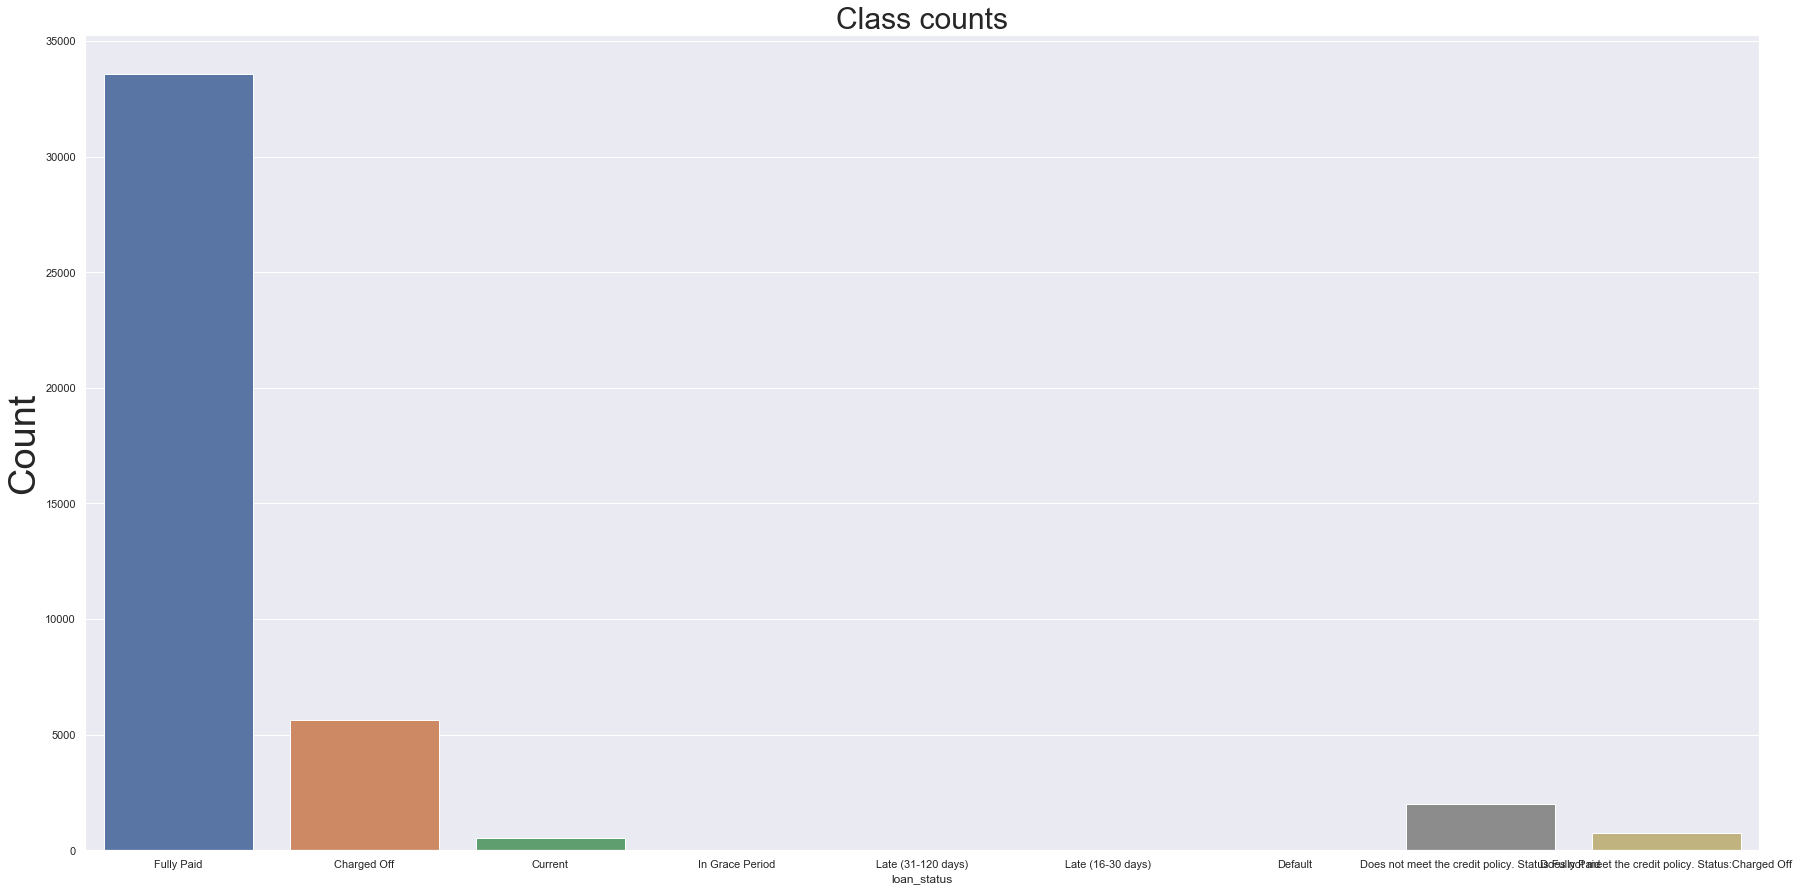

In [88]:
# Analyse deeply the contain of 'Loans_Status'
pos = loans_2007['loan_status'].value_counts(normalize=True)
print(pos)
plt.figure(figsize=(30, 15))
sns.countplot(loans_2007['loan_status'])
plt.ylabel("Count", fontsize=18)
plt.title("Class counts", y=1, fontdict={"fontsize": 30});

We have 15 features with missing values. The number of Charge Off loans represent only 13 perc of the data. Which one of the 09 possible values could be used for modelling? Let's understand these 09 features...



In [104]:
meaning = [
"Loan has been fully paid off.",
"Loan for which there is no longer a reasonable expectation of further payments.",
"While the loan was paid off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.",
"While the loan was charged off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.",
"Loan is up to date on current payments.",
"The loan is past due but still in the grace period of 15 days.",
"Loan hasn't been paid in 31 to 120 days (late on the current payment).",
"Loan hasn't been paid in 16 to 30 days (late on the current payment).",
"Loan is defaulted on and no payment has been made for more than 121 days."]


status, count = loans_2007["loan_status"].value_counts().index, loans_2007["loan_status"].value_counts(normalize=True).values
loan_statuses_explanation = pd.DataFrame({'Loan Status': status,'Count': count,'Meaning': meaning})[['Loan Status','Count','Meaning']]
loan_statuses_explanation

,Loan Status,Count,Meaning
0,Fully Paid,0.789609,Loan has been fully paid off.
1,Charged Off,0.132902,Loan for which there is no longer a reasonable expectation of further payments.
2,Does not meet the credit policy. Status:Fully Paid,0.046738,"While the loan was paid off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace."
3,Does not meet the credit policy. Status:Charged Off,0.017891,"While the loan was charged off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace."
4,Current,0.012061,Loan is up to date on current payments.
5,In Grace Period,0.000376,The loan is past due but still in the grace period of 15 days.
6,Late (31-120 days),0.000282,Loan hasn't been paid in 31 to 120 days (late on the current payment).
7,Late (16-30 days),0.000118,Loan hasn't been paid in 16 to 30 days (late on the current payment).
8,Default,0.000024,Loan is defaulted on and no payment has been made for more than 121 days.


Let s keep only 'Fully Paid' and 'Charged Off' and drops the others. The other values describe loans that are still ongoing, and even though some loans are late on Payments

In [110]:
# Get number of positive and negative examples
pos = loans_2007[loans_2007['loan_status'] == 'Fully Paid'].shape[0] # Assuming this is positive
neg = loans_2007[loans_2007['loan_status'] == 'Charged Off'].shape[0] # Assuming this is negative

print(f"Proportion of Fully Paid to Charged Off = {(neg / pos) * 100:.2f}%")

Proportion of Fully Paid to Charged Off = 16.83%
